In [1]:
import numpy as np
from scipy.sparse.linalg import svds
from sklearn import model_selection
from sklearn.metrics.pairwise import cosine_similarity


import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import SVD, KNNWithMeans
from sklearn.model_selection import train_test_split, GridSearchCV



---## Q1. Read and explore the given dataset.  (Rename column/add headers, plot histograms, find data characteristics)
### Load the Dataset

In [3]:
# Load the dataset into a Pandas dataframe called ratingsand skip any lines that return an error
ratings = pd.read_csv('ratings_Electronics.csv', 
                      names=['userId', 'productId', 'rating', 'timestamp'], 
                      error_bad_lines=False, 
                      warn_bad_lines=False)

# Save an original copy of the dataframe
ratings_original = ratings.copy(deep=True)

In [4]:
# Check the head of the dataset
ratings.head()
# Check the tail of the dataset
ratings.tail()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.000,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.000,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.000,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.000,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.000,1334707200


,userId,productId,rating,timestamp
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.000,1396569600
7824478,A322MDK0M89RHN,BT008UKTMW,5.000,1313366400
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.000,1404172800
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.000,1297555200
7824481,A2G81TMIOIDEQQ,BT008V9J9U,5.000,1312675200


**Comments**
- To take a closer look at the data, pandas library provides **“.head()”** function which returns first five observations and **“.tail()”** function which returns last five observations of the data set.

### Inspect the Dataset

In [5]:
# Get the shape and size of the dataset
print("Number of rows    :",ratings.shape[0])
print("Number of columns :",ratings.shape[1])

Number of rows    : 7824482
Number of columns : 4


In [6]:
# Get more info on it
# 1. Name of the columns
# 2. Find the data types of each columns
# 3. Look for any null/missing values
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
userId       object
productId    object
rating       float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [7]:
# Check for any Null values in the dataset
ratings.isnull().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

**Observations**
- The dataset comprises of **7824482 rows** and **4 columns**.
- There are **NO null/missing** present in the dataset.
- int64 datatype of timestamp column indicates that it is in **Unix timestamp** format where each number is the number of seconds passed after **January 1, 1970 at UTC**.

#### Drop Duplicates
It's not certain how this data was collected or if it processed before it was published; there could be some duplicated ratings in here. To check, we'll see if there are any duplicated userId and productId combination.

In [8]:
# Get a dataframe consisting only of ratings that are duplicated
rating_combination = ['userId', 'productId']
ratings[ratings.duplicated(subset=rating_combination, keep=False)].sort_values(rating_combination).head()

# ratings.drop_duplicates(subset=['userId','productId','rating'],inplace=True)

,userId,productId,rating,timestamp


In [12]:
# Drop the timestamp column
ratings.drop(labels='timestamp', axis=1, inplace=True)
ratings.head()

,userId,productId,rating
0,AKM1MP6P0OYPR,0132793040,5.000
1,A2CX7LUOHB2NDG,0321732944,5.000
2,A2NWSAGRHCP8N5,0439886341,1.000
3,A2WNBOD3WNDNKT,0439886341,3.000
4,A1GI0U4ZRJA8WN,0439886341,1.000


In [13]:
# Check the count of unique user and product data
unique_original = (ratings.userId.nunique(), ratings.productId.nunique())
print('Count of unique Users    :', unique_original[0])
print('Count of unique Products :', unique_original[1])

Count of unique Users    : 4201696
Count of unique Products : 476002


In [14]:
# Find the minimum and maximum ratings
print("The Minimum rating is:",ratings.rating.min())
print("The Maximum rating is:",ratings.rating.max())

The Minimum rating is: 1.0
The Maximum rating is: 5.0


Count of observations in each ratings:


5.000    4347541
4.000    1485781
1.000     901765
3.000     633073
2.000     456322
Name: rating, dtype: int64

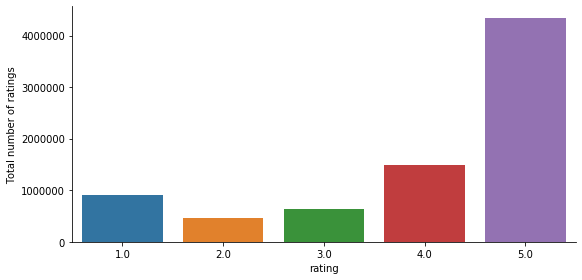

In [15]:
# Check the distribution of ratings 
print('Count of observations in each ratings:')
ratings.rating.value_counts()
g = sns.factorplot("rating", data=ratings, aspect=2.0, kind='count')
g.set_ylabels("Total number of ratings")

In [16]:
# Find the unique products under each ratings
ratings.groupby('rating')['productId'].nunique()

rating
1.000    176283
2.000    123419
3.000    152827
4.000    223845
5.000    358458
Name: productId, dtype: int64

**Observations:**
- Extreme high count in rating 5 indicates Amazon delivers good quality products in electronics department.
- Count plot and number of unique product under each rating category shows that there is more frequency under rating 5 followed by rating 4 and rating 1.
- This means ideally people are more sensitive towards extreme experiences. In other words more ratings can be observed when users are extremely satisfied or extremely unsatisfied.
- Users do not bother to rate usually for the average experience with any product, so is the reason rating 2 and 3 are having lesser frequency compared to others.

---
## Q2. Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 50 or more number of ratings)
### Data Sparsity
Many recommender systems run into a problem called the **Cold-Start problem**. Essentially, a user can't be recommended anything because they haven't rated anything! Additionally, if you introduce a new product, nobody has rated it and it can't be recommended. Since we have rating data, we're going to run into either of these problems. Because of this problem, also the mathematical space becomes very much sparse.

If a user has rated one or very few items, how well could a recommender system work? If we have one point of a line, we have no idea which direction the line is going. In the same vein, if we have a user with only one or very few ratings, though we might be able to rule out some items, but it would be very difficult to be confident in our recommendations for that user.

For this reason, I'm going to explore how many ratings have been submitted per user.

In [17]:
# Find the top 10 users based on ratings
most_rated = ratings.userId.value_counts().rename_axis('UserId').reset_index(name='# ratings')
# most_rated = ratings.groupby('userId').size().sort_values(ascending=False)
most_rated.head(10)

,UserId,# ratings
0,A5JLAU2ARJ0BO,520
1,ADLVFFE4VBT8,501
2,A3OXHLG6DIBRW8,498
3,A6FIAB28IS79,431
4,A680RUE1FDO8B,406
5,A1ODOGXEYECQQ8,380
6,A36K2N527TXXJN,314
7,A2AY4YUOX2N1BQ,311
8,AWPODHOB4GFWL,308
9,ARBKYIVNYWK3C,296


In [19]:
# Drop the users who have rated less than 50 products
ratings = ratings[ratings.userId.isin(most_rated[most_rated['# ratings'] >= 50].UserId)]
print('# unique USERS who have rated 50 or more products :', ratings.userId.nunique())
print('# unique USERS dropped      :', unique_original[0] - ratings.userId.nunique())
print('# unique ITEMS remaining    :', ratings.productId.nunique())
print('# unique ITEMS dropped      :', unique_original[1] - ratings.productId.nunique())
print('\nFinal length of the dataset :', len(ratings))

# unique USERS who have rated 50 or more products : 1540
# unique USERS dropped      : 4200156
# unique ITEMS remaining    : 48190
# unique ITEMS dropped      : 427812

Final length of the dataset : 125871


**Observations:**
- There was a huge no of users (4200156) who haven't rated atleast 50 products. These records would not have drawn a proper intuation about user similarity considering the total no. of records in the dataset. Hence we dropped all such users and are now left with **1540 unique users** with 50 or more ratings under each one's umbrella. Which is almost **0.04%** of total no of users in the original dataset.
- In the process of getting rid of such users, we ended up dropping 427812 unique products and their ratings. Now we are left with only **48190 unique products** which is almost **10%** of the original list of products.
- As a whole we **dropped** 7824482-125871=**7698611 records** which is almost **98.4%** of the original dataset.

## Q3. Split the data randomly into train and test dataset. (For example split it in 70:30 ratio)

In [22]:
# Divide the dataset in 70:30 ratio
trainset, testset = model_selection.train_test_split(ratings, test_size=0.3, random_state=5)
trainset.head()
testset.head()

,userId,productId,rating
5815696,A197T2N6RU7K56,B007N6OED8,5.000
412740,A3HR0ZZOFKQ97N,B0001Y7UAI,5.000
444340,AGHZXQL9F94T9,B0002A6YVC,2.000
3481712,A2XJMQ2COPGWJH,B003NSBF32,2.000
4580022,A2D1LPEUCTNT8X,B004YKKT26,4.000


,userId,productId,rating
4930282,A2UOHALGF2X77Q,B005G81E9M,3.000
3333831,A27M75LRSJ788H,B003FG6IV6,5.000
7490425,A35W3JQYP0M655,B00E3FHXYO,5.000
679608,A1FR68QH6Z4YZM,B0009R3N9E,5.000
583942,A25FL6VLD7S23S,B00079Q5DK,2.000


In [23]:
print('Shape of the training set  :', trainset.shape)
print('Shape of the test set      :', testset.shape)

Shape of the training set  : (88109, 3)
Shape of the test set      : (37762, 3)


**Observations**:
- Train Test set split resulted into 88109 training data and 37762 testing dataset.
- Both the datasets are having almost equal no of data points under each rating.

---
## Q4. Build Popularity Recommender model. (Non-personalised)
### Popularity Based
Easiest way to build a recommendation system is popularity based, simply over all the products that are popular, So how to identify popular products, which could be identified by which are all the products that are bought most.

Let's group the products to find the count of reatings each one of them has recieved. this could be considered as their individual scores.

In [25]:
# Create a method to recommend products based on popularity
def recommend_popular(df, top_n, userId=None):
    # Generate a recommendation rank based upon score 
    df['Rank'] = df['score'].rank(ascending=0, method='first') 
    recommendations = df.sort_values(['score', 'productId'], ascending=[0,1])
    
    # Add UserId column for which the recommendations are being generated 
    if userId:
        recommendations.insert(0,'userId',userId)
    
    # Get the top N recommendations 
    return recommendations.head(top_n)

**Method 1**: Average of ratings for each unique product as recommended score<br/>
The score for each product in this method is calculated as the average of the ratings recieved. This method is better than method 1.

In [28]:
#Count of user_id for each unique product as recommendation score 
product_grp = ratings.groupby(['productId']).agg({'rating': 'mean'}).reset_index()
product_grp.rename(columns={'rating': 'score'}, inplace=True)
product_grp.head()

,productId,score
0,0594451647,5.000
1,0594481813,3.000
2,0970407998,2.500
3,0972683275,4.750
4,1400501466,3.333


In [29]:
# Find recommendation for top 5 products
recommend_popular(product_grp, 5)

,productId,score,Rank
0,0594451647,5.000,1.000
5,1400501520,5.000,2.000
12,1400699169,5.000,3.000
13,1685560148,5.000,4.000
14,3744295508,5.000,5.000


---
**Method 2**: Sum of ratings for each unique product as recommended score<br/>
The score for each product in this method is calculated as the sum of all ratings recieved. This is practically the best approach to determine the popularity of an item considering only the users ratings are given. This is also preferred over avg (method 2) as average of one 5 star rating is exactly same as the average of more than one 5 star ratings, but the product with more 5 star ratings would be considered as the most popular.

In [30]:
#Count of user_id for each unique product as recommendation score 
product_grp = ratings.groupby(['productId']).agg({'rating': 'sum'}).reset_index()
product_grp.rename(columns={'rating': 'score'}, inplace=True)
product_grp.head()

,productId,score
0,0594451647,5.000
1,0594481813,3.000
2,0970407998,5.000
3,0972683275,19.000
4,1400501466,20.000


In [31]:
# Find recommendation for top 5 products
recommend_popular(product_grp, 5)

,productId,score,Rank
24827,B003ES5ZUU,895.000,1.000
39003,B0088CJT4U,869.000,2.000
11078,B000N99BBC,797.000,3.000
38250,B007WTAJTO,771.000,4.000
38615,B00829TIEK,661.000,5.000


In [32]:
# Find recommendation for couple of users
find_recom = {'A197T2N6RU7K56': 6, 
              'A1FR68QH6Z4YZM': 3, 
              'A10AFVU66A79Y1': 8}   # This list is user, top_n recommendation dict.
for user in find_recom:
    print("Top %d recommendations for the userId: %s" %(find_recom[user],user))
    recommend_popular(product_grp,find_recom[user],user)
    print("\n") 

Top 6 recommendations for the userId: A197T2N6RU7K56


,userId,productId,score,Rank
24827,A197T2N6RU7K56,B003ES5ZUU,895.000,1.000
39003,A197T2N6RU7K56,B0088CJT4U,869.000,2.000
11078,A197T2N6RU7K56,B000N99BBC,797.000,3.000
38250,A197T2N6RU7K56,B007WTAJTO,771.000,4.000
38615,A197T2N6RU7K56,B00829TIEK,661.000,5.000
38611,A197T2N6RU7K56,B00829THK0,605.000,6.000




Top 3 recommendations for the userId: A1FR68QH6Z4YZM


,userId,productId,score,Rank
24827,A1FR68QH6Z4YZM,B003ES5ZUU,895.000,1.000
39003,A1FR68QH6Z4YZM,B0088CJT4U,869.000,2.000
11078,A1FR68QH6Z4YZM,B000N99BBC,797.000,3.000




Top 8 recommendations for the userId: A10AFVU66A79Y1


,userId,productId,score,Rank
24827,A10AFVU66A79Y1,B003ES5ZUU,895.000,1.000
39003,A10AFVU66A79Y1,B0088CJT4U,869.000,2.000
11078,A10AFVU66A79Y1,B000N99BBC,797.000,3.000
38250,A10AFVU66A79Y1,B007WTAJTO,771.000,4.000
38615,A10AFVU66A79Y1,B00829TIEK,661.000,5.000
38611,A10AFVU66A79Y1,B00829THK0,605.000,6.000
39338,A10AFVU66A79Y1,B008DWCRQW,561.000,7.000
28761,A10AFVU66A79Y1,B004CLYEDC,551.000,8.000


**Observations:**
- Popularity recommender models works based on the popularity of products.
- The products with highest number of ratings gets recommended irrespective of user's interest. This is the model used as a basic recommendation even when the user is not even logged into Amazon.
- So is observed above that all the 3 users recieved the same recommendations i.e the top n rated products under Electronics category.

---
## Q5. Build Collaborative Filtering model
### Collaborative Filtering


In [33]:
# Create the User-Item sparse matrix
user_item = ratings.pivot(index='userId', columns='productId', values='rating').fillna(0)
print('Shape of User-Item sparse matrix:', user_item.shape)
user_item.head()

Shape of User-Item sparse matrix: (1540, 48190)


productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
A100WO06OQR8BQ,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
A105S56ODHGJEK,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
A105TOJ6LTVMBG,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
A10AFVU66A79Y1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [34]:
# Create the Item-User sparse matrix
item_user = ratings.pivot(index='productId', columns='userId', values='rating').fillna(0)
print('Shape of Item-User sparse matrix:', item_user.shape)
item_user.head()

Shape of Item-User sparse matrix: (48190, 1540)


userId,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
productId,,,,,,,,,,,,,,,,,,,,,
0594451647,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
0594481813,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
0970407998,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
0972683275,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1400501466,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


Now, we will calculate the similarity. We can use the cosine_similarity function from sklearn to calculate the cosine similarity.

In [35]:
# Calculate the user-user similarity
user_similarity = cosine_similarity(user_item)
np.fill_diagonal(user_similarity, 0)
user_similarity_df = pd.DataFrame(user_similarity,index=user_item.index, columns=user_item.index)
user_similarity_df.head()

userId,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.000,0.011,0.000,0.015,0.026,0.000,0.024,0.034,0.012,0.020,...,0.025,0.000,0.000,0.025,0.036,0.000,0.000,0.038,0.016,0.014
A100WO06OQR8BQ,0.011,0.000,0.013,0.016,0.009,0.010,0.013,0.020,0.017,0.002,...,0.015,0.003,0.012,0.000,0.021,0.018,0.000,0.017,0.000,0.003
A105S56ODHGJEK,0.000,0.013,0.000,0.000,0.022,0.065,0.000,0.000,0.032,0.000,...,0.000,0.000,0.028,0.000,0.011,0.000,0.000,0.004,0.023,0.000
A105TOJ6LTVMBG,0.015,0.016,0.000,0.000,0.000,0.000,0.017,0.003,0.000,0.000,...,0.036,0.000,0.011,0.000,0.016,0.020,0.000,0.040,0.000,0.000
A10AFVU66A79Y1,0.026,0.009,0.022,0.000,0.000,0.021,0.000,0.000,0.000,0.015,...,0.000,0.000,0.015,0.036,0.050,0.000,0.000,0.000,0.000,0.000


In [36]:
# Calculate the item-item similarity
item_similarity = cosine_similarity(item_user)
np.fill_diagonal(item_similarity, 0)
item_similarity_df = pd.DataFrame(item_similarity, index=item_user.index, columns=item_user.index)
item_similarity_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
productId,,,,,,,,,,,,,,,,,,,,,
0594451647,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
0594481813,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
0970407998,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
0972683275,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.261,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1400501466,0.000,0.000,0.000,0.000,0.000,0.539,0.421,0.000,0.000,0.523,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


Now that we have both the smiliarity matrices in our hand, let's see the n-Neighborhood.

In [37]:
# Method to find top N neighbors
def find_n_neighbors(df,n):
    order = np.argsort(df.values, axis=1)[:, :n]
    df = df.apply(axis=1, func=lambda x: pd.Series(x.sort_values(ascending=False).iloc[:n].index,
                                                   index=['top{}'.format(i) for i in range(1, n+1)]))
    return df

In [38]:
# Find 10 neighbors of each user
user_10_neighbors = find_n_neighbors(user_similarity_df, 10)
user_10_neighbors.head(10)

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
userId,,,,,,,,,,
A100UD67AHFODS,A2FZQF0MH29VYN,A11FX8HL2ANK6T,A3CG93783LP0FO,A2NOW4U7W3F7RI,A2LB4FLRZG6CUV,A2DG63DN704LOI,AT53ZTTO707MB,A2XX2A4OJCDNLZ,A33XMCG1UFDSY2,A2YW6XOID7GV6G
A100WO06OQR8BQ,A3963R7EPE3A7E,A30UP2KKD5IQEP,A2Y3WWPUKIJ59I,A298GL2D0BHGKZ,A1CST2WUA32GP0,A15XI2BEGGFEOW,A3D822N1K2IAQD,A2L4ZGN7GZJ95T,A18S2VGUH9SCV5,AXP8GO5Q3AXSA
A105S56ODHGJEK,A17UNMURMLX0ZE,ABMNX856X89CS,ANTN61S4L7WG9,A2LF16F0KX9L7P,A2UKE7GIVC7XFW,AJX9A4Q19UTJU,A2R1HUYHXV7H18,A3J3ZHGDUDPCFL,A1WXG10FJ353K0,A20L63B48RPSOH
A105TOJ6LTVMBG,A1TQBAHI3M4ZBQ,A10ZFE6YE0UHW8,A2XXBZPQT5EXHV,A1NZLRAZJGD99W,A1D27BCSYV7VWH,AVTJEWTCJ3PBE,AAK6SOEJY30YG,A2GKMXRLI7KLFP,A2VCXIAWCPQ13P,AKSFZ4G1AXYFC
A10AFVU66A79Y1,ACQYIC13JXAOI,A25QJBK33C4O0R,A2PMR2PIGWKCQ9,A4H4KYSM2KQ85,A2TVH2OBNXYXHV,A84FLVDK2R5JF,A2UOHALGF2X77Q,A24RCBRDXRXR0Y,A2IFKH3TJ10387,A3JLOIXFM75QNV
A10H24TDLK2VDP,ANTN61S4L7WG9,A2QRXQPHDMFCQV,A3V2EZ6MA32FF6,A3SP7T2PZ3HSDE,AO09RWV40IX78,A3J3ZHGDUDPCFL,A3QNQQKJTL76H0,A1RL1OTV8IJMVD,A19W47CXJJP1MI,A3LDLV1GWQJLEQ
A10NMELR4KX0J6,ARC5ASW9CUAGP,A1PS4OYWUB0VX,A3F7USIDJBR8WU,A3GX0FAMEXV6FB,A32HSNCNPRUMTR,A1L5TA5UQF7EWE,A3223W5IROMYTY,A1ZPUEHF4AES86,A17W0GMB0YY83M,A2HV76MYH7UL3S
A10O7THJ2O20AG,AWSK1ZAEU1KFL,A365PBEOWM7EI7,AZ8XSDMIX04VJ,AN9CP6J4JF91X,AJEOFP6ZWY0MK,A2HRHF83I3NDGT,A24P4E3RJ6AX94,A28621TSIR5EOG,A1VLE2SH9J8WYS,A2A4X545ERLS7H
A10PEXB6XAQ5XF,A267FU71Z01CIH,A1TR1R2QKWRSRA,A2MJ8OL2FYN7CW,A1CMD08Z49PGKQ,A2BLFCOPSMBOZ9,A2CWIYIETNBAK3,A1MCH5RXDOH87H,A28X0LT2100RL1,A1PI8VBCXXSGC7,AJX9A4Q19UTJU


In [39]:
# Find 10 neighbors of each item
item_10_neighbors = find_n_neighbors(item_similarity_df, 10)
item_10_neighbors.head(10)

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
productId,,,,,,,,,,
0594451647,B005B47AIU,B005OIB714,B0076AUCKU,B0058FN6V2,B0073V1NP0,B000MYOJMY,B00AV1UWWY,B005J8OBJE,B004EHSP3Y,B008UMF3T8
0594481813,B00D30UX8I,B0009YFS4A,B00BSE79KQ,B00C80UFJQ,B00CBDUD60,B009WESJEY,B007C2IKQU,B007NNTLK2,B001QSD5GQ,B007XACV8O
0970407998,B00009R8D3,B00078Y24K,B001E9BIU2,B001EYU6Q4,B0015IOUK2,B000XALL8W,B001ADUCTU,B005JY5XK4,B001CT00AS,B001CT00BW
0972683275,B007J4BOWI,B008U25LI6,B003ICXCZM,B004HW67MW,B003GZDB1Q,B0002ZPIXM,B001TLEXES,B00681RUR6,B00009UH9J,B008LCVREM
1400501466,B0049QV65O,B00BC4J5O0,B0098JS19G,B002LITT3S,B000GT6HAM,B000J46TFW,B002WV6LA8,B00462RU60,B004P1ITV2,B00094OWKQ
1400501520,B0030LKGAU,B0053EVW1Y,B004HO58NO,B002YIG8BQ,B004P1ITV2,B00462RU60,B004P1ITU8,B000GT6HAM,B00009W3U9,B0053EVVTW
1400501776,B00462RU60,B003D2BS4E,B0053EVVTW,B004P1ITV2,B004P1ITU8,B002YIG8BQ,B005KHFF2Q,B000FSILBM,B000GT6HAM,B008I6672I
1400532620,B00BGTN06A,B006K59QRC,B002NFZSL6,B007AHQMTO,B00004WHFL,B00BJ91VEA,B0010KWCWI,B00AEFFLJQ,B00GQTDOC0,B00ASQJTY4
1400532655,B005JHF5RM,B004NTO2I0,B0034XDTF8,B000E39V9E,B0003009E4,B002V92X9Y,B000MNA082,B007STXHTM,B001S0RTXM,B007COEPO4


Let's verify the similarity in both item and user base to find out if our calculatios are correct

In [40]:
def get_users_similar_products(user1, user2):
    common_products = ratings[ratings.userId == user1].merge(
    ratings[ratings.userId == user2],
    on = "productId",
    how = "inner" )
    return common_products[['rating_x', 'rating_y', 'productId']].head()

In [41]:
# Check the similarity of two users
get_users_similar_products('A100UD67AHFODS', 'A2FZQF0MH29VYN')

,rating_x,rating_y,productId
0,5.000,5.000,B0002KVQBA
1,3.000,4.000,B002HWRJY4
2,4.000,5.000,B0071BTJPI
3,5.000,5.000,B0097BEFYA
4,5.000,5.000,B00A83I8G2


**Observations**:
- From the above step we can see that the similarity we generated is true since both the given users (**A100UD67AHFODS**, **A2FZQF0MH29VYN**) have almost same ratings and likings.

item_similarity and user_similarity are item-item and user-user similarity matrix in an array form respectively. The next step is to make predictions based on these similarities. Let’s define a function to do just that.

In [42]:
# Method to predict the rating
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

Finally, we will make predictions based on user similarity and item similarity and recommend product based on similarity.

In [43]:
# Predict the ratings for both UBCF and IBCF
st=time()
user_prediction = predict(user_item, user_similarity, type='user')
user_prediction = pd.DataFrame(user_prediction, index=user_item.index, columns=user_item.columns)
user_prediction.head()

item_prediction = predict(user_item, item_similarity, type='item')
# Commenting out following 2 lines as it throws MemoryError due to the high sparsity
# item_prediction = pd.DataFrame(item_prediction, index=item_user.index, columns=item_user.columns)
# item_prediction.head()
print('Time taken %.2fs to find out the user and item prediction' % (time()-st))

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.017,0.002,0.006,0.012,0.014,0.006,0.010,0.002,0.032,0.006,...,0.002,0.015,0.009,0.018,0.013,0.021,0.002,0.038,0.025,0.002
A100WO06OQR8BQ,0.006,0.002,0.004,0.021,0.009,0.006,0.019,0.002,0.011,0.005,...,0.002,0.019,0.002,0.009,0.005,0.002,0.009,0.014,0.006,0.004
A105S56ODHGJEK,-0.003,-0.003,-0.001,0.003,0.003,-0.003,-0.001,-0.000,0.003,-0.002,...,-0.003,0.006,-0.003,0.000,0.005,-0.003,-0.003,0.020,-0.003,0.001
A105TOJ6LTVMBG,-0.002,0.002,0.001,0.015,0.006,-0.002,-0.002,-0.002,0.011,-0.002,...,-0.002,-0.002,-0.002,-0.002,0.001,0.008,-0.002,0.010,0.003,-0.002
A10AFVU66A79Y1,-0.003,-0.003,0.005,0.010,0.010,0.003,0.006,-0.002,0.004,0.004,...,-0.003,0.012,0.004,0.000,-0.001,-0.003,-0.003,0.013,0.004,-0.003


Time taken 1203.40s to find out the user and item prediction


In [44]:
# Method to Recommend the items with the highest predicted ratings
def recommend_items(userId, orig_df, preds_df, top_n):
    # Get and sort the user's ratings
    sorted_user_ratings = orig_df.loc[userId].sort_values(ascending=False) #sorted_user_ratings
    sorted_user_predictions = preds_df.loc[userId].sort_values(ascending=False) #sorted_user_predictions

    # Prepare recommendations
    recommedations = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    recommedations.index.name = 'Recommended Items'
    recommedations.columns = ['user_ratings', 'user_predictions']
    
    # Take the products which user has NOT rated
    recommedations = recommedations.loc[recommedations.user_ratings == 0] 
    recommedations = recommedations.sort_values('user_predictions', ascending=False)
    return recommedations.head(top_n)

In [45]:
# Find recommendation for couple of users using UBCF
find_recom = {'A100UD67AHFODS': 6, 
              'A100WO06OQR8BQ': 3, 
              'A105S56ODHGJEK': 8}   # This list is user, top_n recommendation dict.
for user in find_recom:
    print("Top %d recommendations for the userId: %s" %(find_recom[user],user))
    recommend_items(user, user_item, user_prediction, find_recom[user])
    print("\n") 

Top 6 recommendations for the userId: A100UD67AHFODS


,user_ratings,user_predictions
Recommended Items,,
B003ES5ZUU,0.000,0.873
B007WTAJTO,0.000,0.684
B0088CJT4U,0.000,0.509
B00G4UQ6U8,0.000,0.485
B002V88HFE,0.000,0.463
B00829THK0,0.000,0.462




Top 3 recommendations for the userId: A100WO06OQR8BQ


,user_ratings,user_predictions
Recommended Items,,
B000N99BBC,0.000,0.883
B00829TIEK,0.000,0.749
B004CLYEDC,0.000,0.730




Top 8 recommendations for the userId: A105S56ODHGJEK


,user_ratings,user_predictions
Recommended Items,,
B0088CJT4U,0.000,1.343
B00829THK0,0.000,0.885
B002R5AM7C,0.000,0.844
B004CLYEDC,0.000,0.836
B004CLYEFK,0.000,0.792
B004T9RR6I,0.000,0.662
B003ES5ZUU,0.000,0.616
B00834SJNA,0.000,0.607


**Observations**:
- Unlike popularity model, the recommendations are personalized here as indicated by the different set of recommendations for different users based on their likings.
- It is taking too long to calculate the item-item similarity as the item base is pretty huge than the user base.


## Q6. Evaluate both the models. (Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data)
### Root Mean Square Error (RMSE)


**Evaluation of User Based CF**

**Evaluation of Item Based CF**

## Q7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.
Let's recommend for 2 users for Top 5 products using all the 3 algorithms


---
## Q8. Summarise your insights.


